<a href="https://colab.research.google.com/github/spatiallysaying/raster2ML/blob/main/examples/Tutorial_raster2ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install library**

In [ ]:
!pip install raster2ML

In [ ]:
!git clone https://github.com/spatiallysaying/raster2ML.git

**Display input raster and vector**

Display a raster (like a satellite or aerial image) overlaid with a shapefile (vector data, like boundaries or roads) in a single plot.

In [ ]:
import rasterio
import rasterio.plot
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

We applied a linear contrast stretch that maps the 2nd to the 98th percentiles of the 16-bit image to the full 8-bit display range (0 to 255). This enhancement will improve the visibility of features in the image while maintaining relative brightness values.

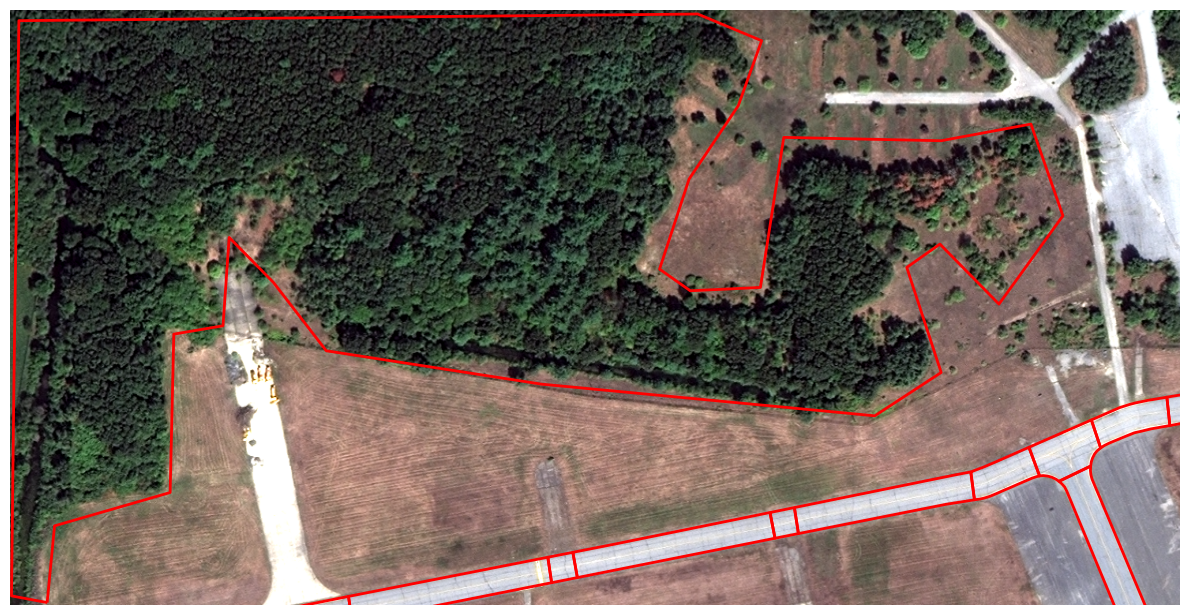

In [30]:
def linear_stretch(input_band, min_val=None, max_val=None):
    if min_val is None:
        min_val = np.percentile(input_band, 2)
    if max_val is None:
        max_val = np.percentile(input_band, 98)
    output_band = np.clip(input_band, min_val, max_val)
    return (output_band - min_val) / (max_val - min_val) * 255

def display_raster_with_shapefile(raster_path, shapefile_path):
    # Load raster
    with rasterio.open(raster_path) as src:
        img_array = src.read((1, 2, 3))  # Assuming a three-band RGB raster, adjust as needed
        img_array = np.dstack(img_array)  # Convert rasterio's (bands, height, width) to (height, width, bands)
        bounds = src.bounds
        transform = src.transform

    # Apply linear stretch to each band for display purposes
    for band in range(img_array.shape[2]):
        img_array[:, :, band] = linear_stretch(img_array[:, :, band])

    # Load vector (shapefile)
    gdf = gpd.read_file(shapefile_path)

    # Check CRS
    if gdf.crs != rasterio.open(raster_path).crs:
        gdf = gdf.to_crs(rasterio.open(raster_path).crs)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img_array, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
    gdf.boundary.plot(ax=ax, color='red', linewidth=2)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
raster_file = "/content/raster2ML/data/in_folder/myraster.tif"
shape_file = '/content/raster2ML/data/in_folder/myvector.shp'
display_raster_with_shapefile(raster_file, shape_file)


#Step.1 Convert an input raster to an 8-bit PNG image

In [10]:
!python  /content/raster2ML/examples/test_raster2png.py  /content/raster2ML/data/in_folder/myraster.tif  /content/raster2ML/data/out_folder

Opening raster... /content/raster2ML/data/in_folder/myraster.tif
/content/raster2ML/data/out_folder/temp_file_c79cfb95-a1df-4ca1-b8a6-f24989cdfceb.tif
/content/raster2ML/data/out_folder/myraster_8bit.png
Calculating statistics...
Rescaling and saving bands...
Writing Band 1...
Writing Band 2...
Writing Band 3...
Completed writing to intermediate ... /content/raster2ML/data/out_folder/temp_file_c79cfb95-a1df-4ca1-b8a6-f24989cdfceb.tif
Completed writing to ... /content/raster2ML/data/out_folder/myraster_8bit.png
File /content/raster2ML/data/out_folder/temp_file_c79cfb95-a1df-4ca1-b8a6-f24989cdfceb.tif deleted successfully!
Deleting intermediate file  ... /content/raster2ML/data/out_folder/temp_file_c79cfb95-a1df-4ca1-b8a6-f24989cdfceb.tif
Operation completed successfully!


Verify

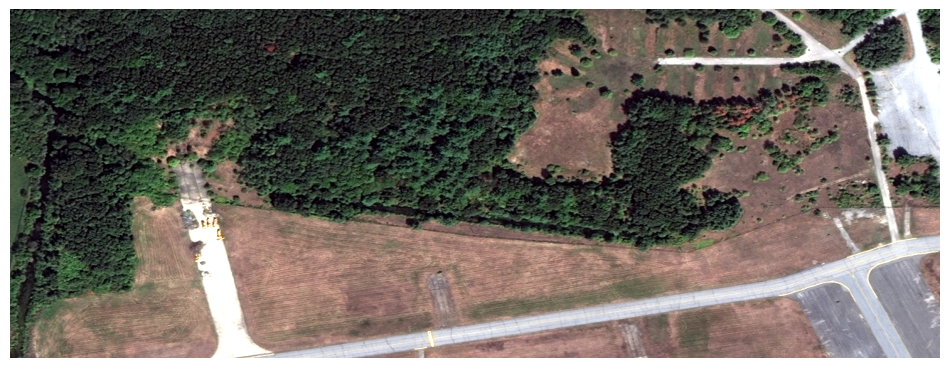

In [20]:
# Example usage
output_8bit_png= '/content/raster2ML/data/out_folder/myraster_8bit.png'

# Read the raster file
with rasterio.open(output_8bit_png) as src:
    fig, ax = plt.subplots(figsize=(12, 12))

    # Display the raster using rasterio's show function
    rasterio.plot.show(src, ax=ax)  # No colormap for RGB
    ax.axis('off')
    plt.show()

# Step.2 Generate a labelme JSON structure using raster(png from Step 1) and shapefile data #

In [ ]:
!python /content/raster2ML/tutorial/test_shp2labelme.py  /content/raster2ML/tutorial/out_folder/myraster_8bit.png  /content/raster2ML/tutorial/in_folder/myvector.shp idlin

Label Me JSON generated at  /content/raster2ML/tutorial/out_folder/myraster_8bit.json


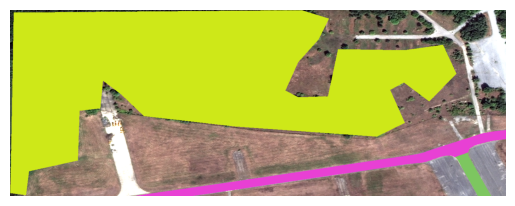

In [28]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from labelme.utils import shape_to_mask

def get_random_color():
    return tuple(np.random.randint(0, 255, 3).tolist())

def display_labelme_overlay(image_path, json_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    shapes = data['shapes']

    # Create a color map for labels
    labels = [shape['label'] for shape in shapes]
    unique_labels = list(set(labels))
    color_map = {label: get_random_color() for label in unique_labels}

    # Overlay the label onto image
    for shape in shapes:
        mask = shape_to_mask(
            img.shape[:2], shape['points'], shape_type=shape.get("shape_type", "polygon")
        )
        color = color_map[shape['label']]
        img[mask] = color

    # Display overlay
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage:
image_path = '/content/raster2ML/data/out_folder/myraster_8bit.png'
json_path = '/content/raster2ML/data/out_folder/myraster_8bit.json'
display_labelme_overlay(image_path, json_path)

# Step.3  Transform a given labelme JSON file into a labeled image (mask)

In [12]:
!python /content/raster2ML/examples/test_labelme2mask.py   /content/raster2ML/data/out_folder/myraster_8bit.json /content/raster2ML/data/out_folder

myraster_8bit_mask
Maks generated at  /content/raster2ML/data/out_folder/myraster_8bit_mask


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


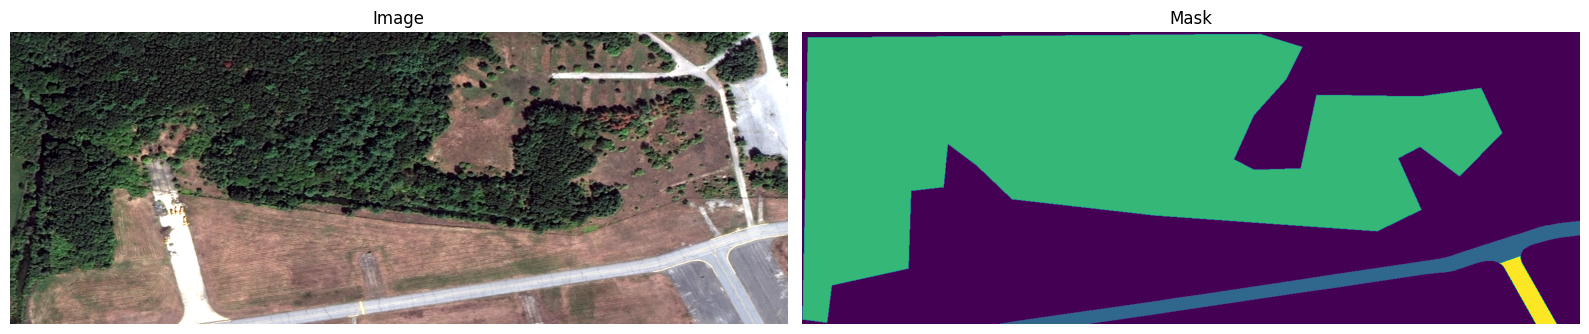

In [22]:
def display_raster_with_raster(raster_path1, raster_path2, title1=None, title2=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

    # Read and display the first raster
    with rasterio.open(raster_path1) as src1:
        rasterio.plot.show(src1, ax=ax1)
        if title1:  # if title is provided, set it
            ax1.set_title(title1)
        ax1.axis('off')

    # Read and display the second raster
    with rasterio.open(raster_path2) as src2:
        rasterio.plot.show(src2, ax=ax2)
        if title2:  # if title is provided, set it
            ax2.set_title(title2)
        ax2.axis('off')

    plt.tight_layout()  # Adjust spaces between the rasters for a neat display
    plt.show()

# Example usage
raster_file1 = "/content/raster2ML/data/out_folder/myraster_8bit.png"
raster_file2 = "/content/raster2ML/data/out_folder/myraster_8bit_mask.png"
display_raster_with_raster(raster_file1, raster_file2, title1="Image", title2="Mask")


# All in one


> Accepts Georeferenced raster and vector files, generates a mask in raster format for the classes picked up from the vector field



In [13]:
!python  /content/raster2ML/examples/raster_and_shape_to_mask.py  \
 /content/raster2ML/data/in_folder/myraster.tif /content/raster2ML/data/in_folder/myvector.shp  \
 idlin  \
 /content/raster2ML/data//out_folder

Raster parsed  4326
Opening raster... /content/raster2ML/data/in_folder/myraster.tif
/content/raster2ML/data//out_folder/temp_file_49a7dfdc-f8e7-4e28-a467-3a88cc6b5594.tif
/content/raster2ML/data//out_folder/myraster_8bit.png
Calculating statistics...
Rescaling and saving bands...
Writing Band 1...
Writing Band 2...
Writing Band 3...
Completed writing to intermediate ... /content/raster2ML/data//out_folder/temp_file_49a7dfdc-f8e7-4e28-a467-3a88cc6b5594.tif
Completed writing to ... /content/raster2ML/data//out_folder/myraster_8bit.png
File /content/raster2ML/data//out_folder/temp_file_49a7dfdc-f8e7-4e28-a467-3a88cc6b5594.tif deleted successfully!
Deleting intermediate file  ... /content/raster2ML/data//out_folder/temp_file_49a7dfdc-f8e7-4e28-a467-3a88cc6b5594.tif
Operation completed successfully!
LabelMe JSON generated at  /content/raster2ML/data//out_folder/myraster_8bit.json
Maks generated at  /content/raster2ML/data//out_folder/myraster_8bit_mask
